# Load Shedding forecasting

The aim of this notebook, is to try and predict the amount of electrical load that willl be shed 6 months after the last data entry date. When the demand for electricity exceeds the available supply, planned supply interruptions may have to be carried out. This is called load shedding. It is a controlled way of rotating the available electricity between all Eskom customers. So the basic formula we will use to calculate load shedding as mentioned above is:

<b>Electrical load to be shed = Supply - Demand</b>

Throughout this notebook, we will be using equations and statistical modelling to break down and numericaly determine what is supply and demand. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
plt.rcParams.update({'figure.figsize' : (9,3), 'figure.dpi' : 120})  
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
%matplotlib inline 
color_pal = sns.color_palette()

import warnings
warnings.filterwarnings("ignore")

# Data
The data we will be using is from Eskom. With hourly data ranging 15 May 2019- 15 May 2023.

In [2]:
dataset = pd.read_excel('ESK5039.xlsx')

# Inspection and cleaning

In [3]:
# We want to see the types of colums in the dataset
dataset.columns

Index(['Datetime', 'Original Res Forecast before Lockdown',
       'Residual Forecast', 'RSA Contracted Forecast',
       'Dispatchable Generation', 'Residual Demand', 'RSA Contracted Demand',
       'International Exports', 'International Imports', 'Thermal Generation',
       'Nuclear Generation', 'Eskom Gas Generation', 'Eskom OCGT Generation',
       'Hydro Water Generation', 'Pumped Water Generation', 'ILS Usage',
       'Manual Load_Reduction(MLR)', 'IOS Excl ILS and MLR',
       'Dispatchable IPP OCGT', 'Eskom Gas SCO', 'Eskom OCGT SCO',
       'Hydro Water SCO', 'Pumped Water SCO Pumping', 'Wind', 'PV', 'CSP',
       'Other RE', 'Total RE', 'Wind Installed Capacity',
       'PV Installed Capacity', 'CSP Installed Capacity',
       'Other RE Installed Capacity', 'Total RE Installed Capacity',
       'Installed Eskom Capacity', 'Total PCLF', 'Total UCLF', 'Total OCLF',
       'Total UCLF+OCLF', 'Non Comm Sentout', 'Drakensberg Gen Unit Hours',
       'Palmiet Gen Unit Hours', 'In

In [4]:
dataset.head()

,Datetime,Original Res Forecast before Lockdown,Residual Forecast,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,...,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours,Unnamed: 42
0,2019-04-01 00:00:00,NaN,20126.707,21100.944,21035.27,21035.27,21795.048,1220.728,919.0,19988.0,...,44104.0,5246.00,10828.725,766.4,11595.125,125.0,1632.0,91.5,48.0,49.77
1,2019-04-01 01:00:00,NaN,19822.447,20826.932,20548.27,20548.27,21498.383,1195.998,834.0,19670.0,...,44104.0,5246.00,10663.279,765.0,11428.000,279.0,1517.0,92.7,49.6,51.27
2,2019-04-01 02:00:00,NaN,19726.316,20765.577,20413.27,20413.27,21409.036,1183.745,765.0,19597.0,...,44104.0,5199.95,10504.001,765.0,11269.000,1.0,1496.0,94.3,51.2,52.83
3,2019-04-01 03:00:00,NaN,19938.506,21027.756,20476.40,20476.40,21469.758,1156.881,739.0,19675.0,...,44104.0,4939.00,10434.095,765.0,11199.000,95.0,1494.0,96.0,53.2,54.39
4,2019-04-01 04:00:00,NaN,20794.305,21928.437,21156.27,21156.27,22204.397,1212.353,926.0,19871.0,...,44104.0,4939.00,10433.393,765.0,11198.000,393.0,1501.0,97.8,55.2,56.05


In [5]:
Dataset = dataset.drop(columns='Original Res Forecast before Lockdown')

In [6]:
Dataset.head(2)


,Datetime,Residual Forecast,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,...,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours,Unnamed: 42
0,2019-04-01 00:00:00,20126.707,21100.944,21035.27,21035.27,21795.048,1220.728,919.0,19988.0,1845.0,...,44104.0,5246.0,10828.725,766.4,11595.125,125.0,1632.0,91.5,48.0,49.77
1,2019-04-01 01:00:00,19822.447,20826.932,20548.27,20548.27,21498.383,1195.998,834.0,19670.0,1845.0,...,44104.0,5246.0,10663.279,765.0,11428.000,279.0,1517.0,92.7,49.6,51.27


In [7]:
# Data for 6months from today

FutureData = Dataset.loc[(Dataset['Datetime'] > '2023-05-16') & (Dataset['Datetime'] < '2023-11-17') ]
FutureData.head()

,Datetime,Residual Forecast,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,...,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours,Unnamed: 42
36145,2023-05-16 01:00:00,20727.707,21591.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36146,2023-05-16 02:00:00,20520.313,21413.825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36147,2023-05-16 03:00:00,20846.602,21671.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36148,2023-05-16 04:00:00,22541.374,23353.149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36149,2023-05-16 05:00:00,25801.719,26612.074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Removing non type values
Dataset.dropna(inplace = True)

In [9]:
#Setting date as index
Dataset.set_index('Datetime', inplace = True)
FutureData.set_index('Datetime', inplace = True)

# Demand

<Axes: title={'center': 'Monthly Demand'}, xlabel='Time(months)', ylabel='Energy (MW)'>

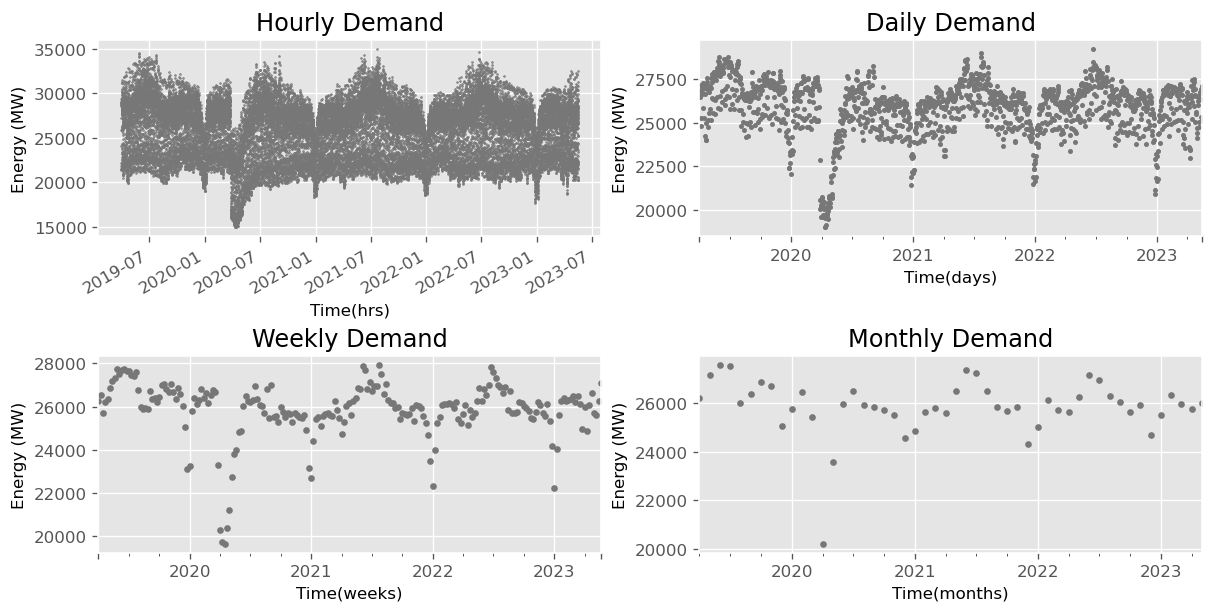

In [10]:
#plot the demand by its features

fig, ax = plt.subplots(2,2, figsize=(10,8),constrained_layout = True,)

Dataset['RSA Contracted Demand'].plot(ax=ax[0,0],style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[3],
          title='Hourly Demand', ylabel='Energy (MW)',xlabel = 'Time(hrs)')

Dataset['RSA Contracted Demand'].resample('D').mean().plot(ax=ax[0,1],style='.',
          figsize=(10, 5),
          ms=4,
          color=color_pal[3],
          title='Daily Demand', ylabel='Energy (MW)',xlabel = 'Time(days)')

Dataset['RSA Contracted Demand'].resample('W').mean().plot(ax=ax[1,0],style='.',
          figsize=(10, 5),
          ms=6,
          color=color_pal[3],
          title='Weekly Demand', ylabel='Energy (MW)',xlabel = 'Time(weeks)')

Dataset['RSA Contracted Demand'].resample('M').mean().plot(ax=ax[1,1],style='.',
          figsize=(10, 5),
          ms=6,
          color=color_pal[3],
          title='Monthly Demand', ylabel='Energy (MW)',xlabel = 'Time(months)')

<Axes: title={'center': 'Hourly Demand'}, xlabel='Datetime', ylabel='Energy (MW)'>

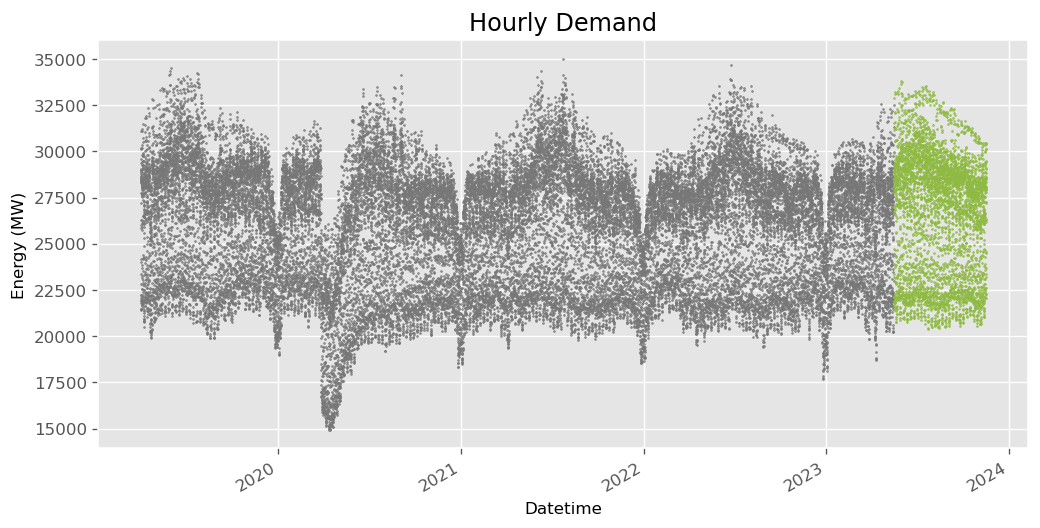

In [11]:
Dataset['RSA Contracted Demand'].plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[3],
          title='Hourly Demand', ylabel='Energy (MW)',xlabel = 'Time(hrs)')
FutureData['RSA Contracted Forecast'].plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[5])

# Supply

## EAF Calculation

Energy Availability Factor of Eskom plant. It is the difference between the maximum availability and all unavailabilities (PCLF, UCLF & OCLF) expressed as a percentage. This excludes renewables, IPPs and international imports.
 
<b>PCLF</b> – Planned Capability Loss Factor of Eskom plant. It is the ratio between the unavailable energy of the units that are out on planned maintenance over a period compared to the total net installed capacity of all units over the same period.

<b>UCLF</b> – Unplanned Capability Loss Factor of Eskom plant. It is the ratio between the unavailable energy of the units that are out on unplanned outages over a period compared to the total net installed capacity of all units over the same period

<b>OCLF</b> – Other Capability Loss Factor of Eskom plant. It is the ratio between the unavailable energy of the units that cannot be dispatched, due to constraints out of the power station management control, over a period compared to the total net installed capacity of all units over the same period.

<Axes: title={'center': 'Historical Outages'}, xlabel='Time(days)', ylabel='Energy (MW)'>

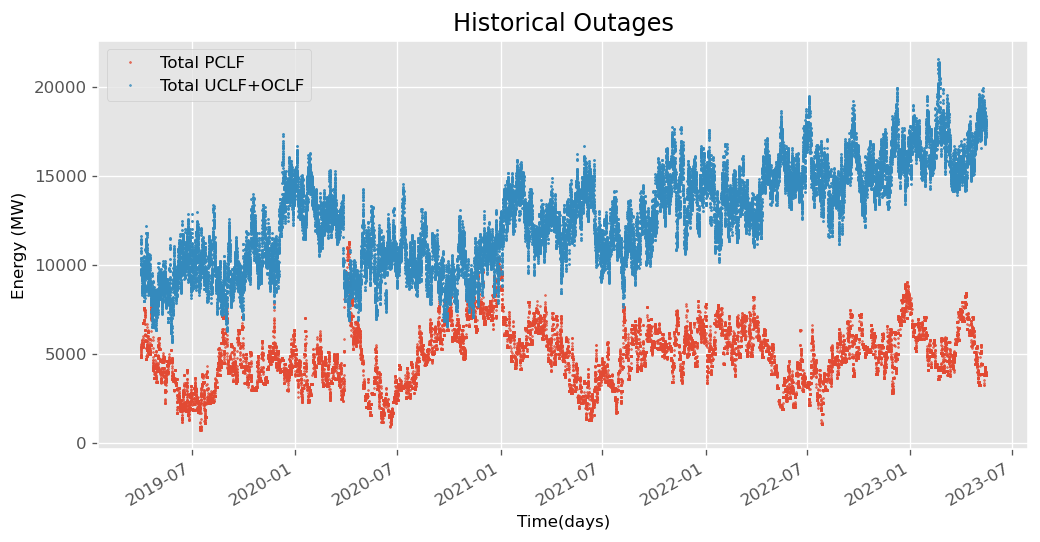

In [12]:

# These are graphs of planned and unplaneed outages
Dataset[['Total PCLF','Total UCLF+OCLF']].plot(style='.',
          figsize=(10, 5),
          ms=1
          , ylabel='Energy (MW)',xlabel = 'Time(days)',title='Historical Outages')

Dataset['Total UCLF+OCLF'].plot(style='.',
          figsize=(10, 5),
          ms=1
          ,color=color_pal[1], ylabel='Energy (MW)',xlabel = 'Time(days)')

In [13]:
# Calculating the EAF from PUCLF, UCLF and OCLF
Dataset['Total_unavail']  =  Dataset['Total PCLF'] + Dataset['Total UCLF'] + Dataset['Total OCLF']


Dataset['EAF'] = (Dataset['Installed Eskom Capacity'] - Dataset['Total_unavail'])/Dataset['Installed Eskom Capacity']

<Axes: title={'center': 'Monthly EAF'}, xlabel='Time(Months)', ylabel='Energy (MW)'>

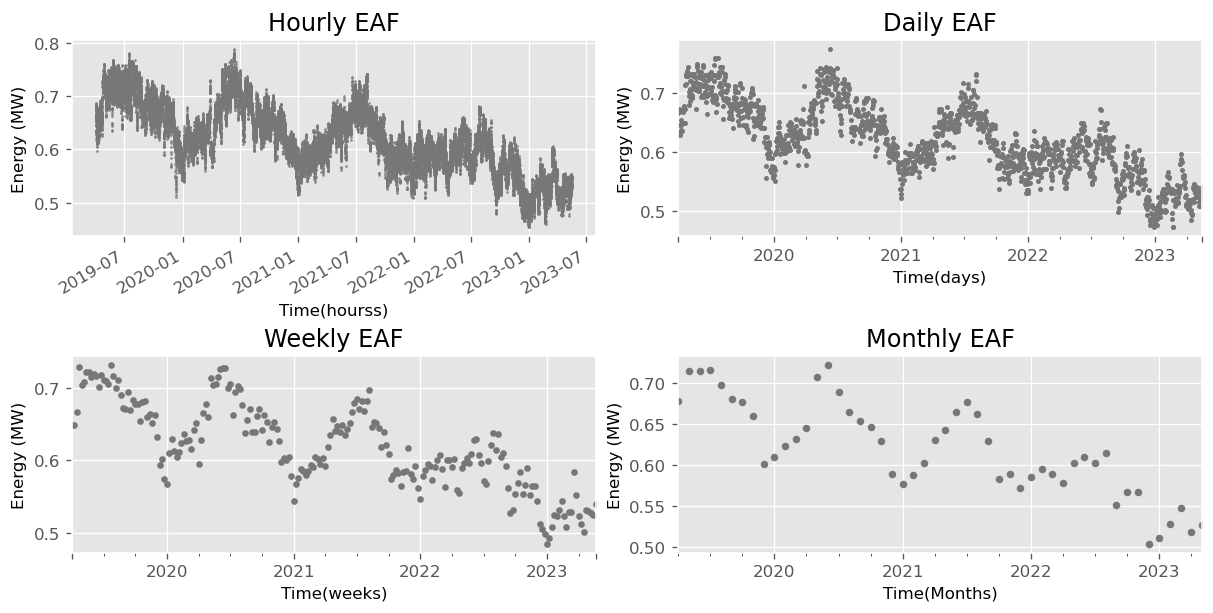

In [14]:
# Different EAF Plots for different  time features

fig, ax = plt.subplots(2,2, figsize=(15,10),constrained_layout = True)

Dataset['EAF'].plot(ax=ax[0,0],style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[3],
          title='Hourly EAF', ylabel='Energy (MW)',xlabel = 'Time(hourss)')

Dataset['EAF'].resample('D').mean().plot(ax=ax[0,1],style='.',
          figsize=(10, 5),
          ms=4,
          color=color_pal[3],
          title='Daily EAF', ylabel='Energy (MW)',xlabel = 'Time(days)')


Dataset['EAF'].resample('W').mean().plot(ax=ax[1,0],style='.',
          figsize=(10, 5),
          ms=6,
          color=color_pal[3],
          title='Weekly EAF', ylabel='Energy (MW)',xlabel = 'Time(weeks)')


Dataset['EAF'].resample('M').mean().plot(ax=ax[1,1],style='.',
          figsize=(10, 5),
          ms=7,
          color=color_pal[3],
          title='Monthly EAF', ylabel='Energy (MW)',xlabel = 'Time(Months)')

## Forecasting future EAF

We will be using the Prophet model to forecast the future EAF. This is because the prophet model is a good model for forecastimg data will multi trends/seasonalities


Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

So, Prophet is the facebooks’ open source tool for making time series predictions.

Prophet decomposes time series data into trend, seasonality and holiday effect.

<b>Trend</b> models non periodic changes in the time series data.

<b>Seasonality</b> is caused due to the periodic changes like daily, weekly, or yearly seasonality.

Holiday effect which occur on irregular schedules over a day or a period of days.

Error terms is what is not explained by the model.



In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet
import datetime as dt
import warnings

def mean_absolute_percentage_error(y_true, y_pred): 
    
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Prophet model takes 2 columns so I will have to put the EAF 

In [16]:
EAF = pd.Series.to_frame(Dataset['EAF'])

In [17]:
EAF

,EAF
Datetime,
2019-04-01 00:00:00,0.618150
2019-04-01 01:00:00,0.621933
2019-04-01 02:00:00,0.626588
2019-04-01 03:00:00,0.634090
2019-04-01 04:00:00,0.634106
...,...
2023-05-15 19:00:00,0.547547
2023-05-15 20:00:00,0.546388
2023-05-15 21:00:00,0.545691


In [18]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(EAF, label='EAF')
features_and_target = pd.concat([X, y], axis=1)

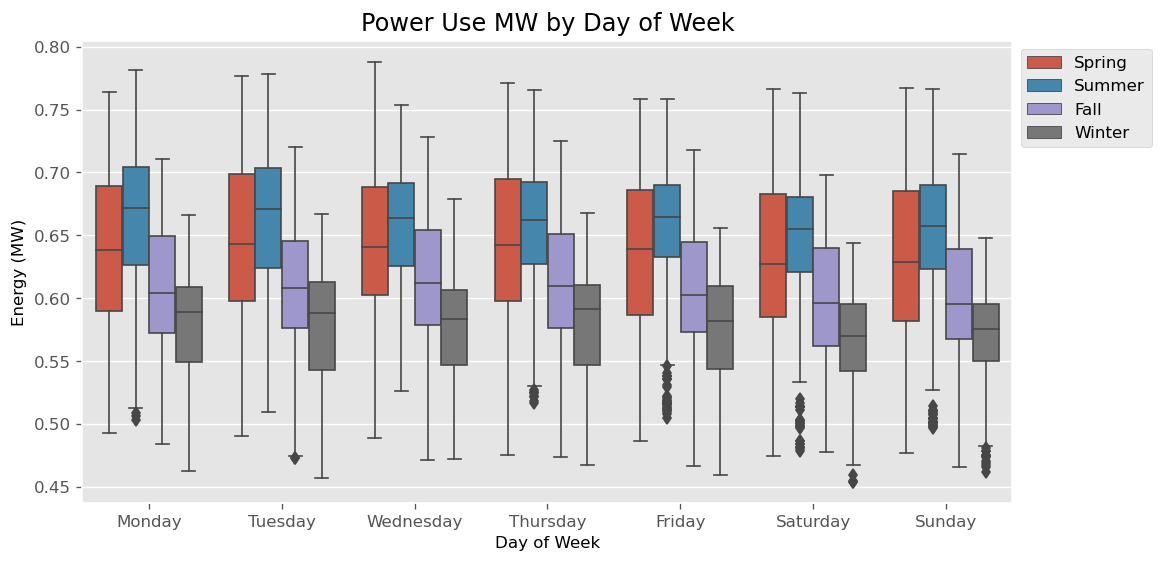

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='EAF',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

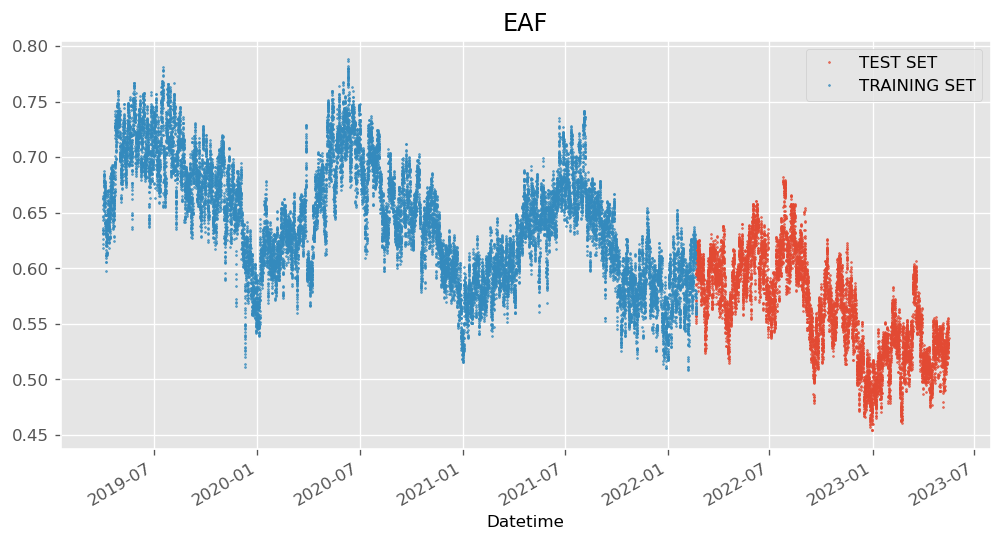

In [20]:
split_date = '20-Feb-2022'
EAF_train = EAF.loc[EAF.index <= split_date].copy()
EAF_test = EAF.loc[EAF.index > split_date].copy()

# Plot train and test so you can see where we have split
EAF_test \
    .rename(columns={'EAF': 'TEST SET'}) \
    .join(EAF_train.rename(columns={'EAF': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='EAF', style='.', ms=1)
plt.show()

In [21]:
# Format data for prophet model using ds and y
EAF_train_prophet = EAF_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'EAF':'y'})

In [22]:
%%time
model = Prophet()
model.fit(EAF_train_prophet)

13:37:33 - cmdstanpy - INFO - Chain [1] start processing
13:38:05 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 5.3 s
Wall time: 38.5 s


In [23]:
# Predict on test set with model
EAF_test_prophet = EAF_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'EAF':'y'})

EAF_test_fcst = model.predict(EAF_test_prophet)

In [24]:
EAF_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-02-20 01:00:00,0.609915,0.559545,0.615755,0.609915,0.609915,-0.020474,-0.020474,-0.020474,-0.000291,...,-0.009639,-0.009639,-0.009639,-0.010545,-0.010545,-0.010545,0.0,0.0,0.0,0.589441
1,2022-02-20 02:00:00,0.609909,0.561648,0.618410,0.609909,0.609909,-0.020346,-0.020346,-0.020346,-0.000598,...,-0.009258,-0.009258,-0.009258,-0.010490,-0.010490,-0.010490,0.0,0.0,0.0,0.589563
2,2022-02-20 03:00:00,0.609902,0.560183,0.620378,0.609902,0.609902,-0.019788,-0.019788,-0.019788,-0.000505,...,-0.008847,-0.008847,-0.008847,-0.010436,-0.010436,-0.010436,0.0,0.0,0.0,0.590114
3,2022-02-20 04:00:00,0.609896,0.561126,0.615875,0.609896,0.609896,-0.018373,-0.018373,-0.018373,0.000418,...,-0.008409,-0.008409,-0.008409,-0.010382,-0.010382,-0.010382,0.0,0.0,0.0,0.591523
4,2022-02-20 05:00:00,0.609889,0.566577,0.622275,0.609889,0.609889,-0.016285,-0.016285,-0.016285,0.001988,...,-0.007945,-0.007945,-0.007945,-0.010328,-0.010328,-0.010328,0.0,0.0,0.0,0.593604


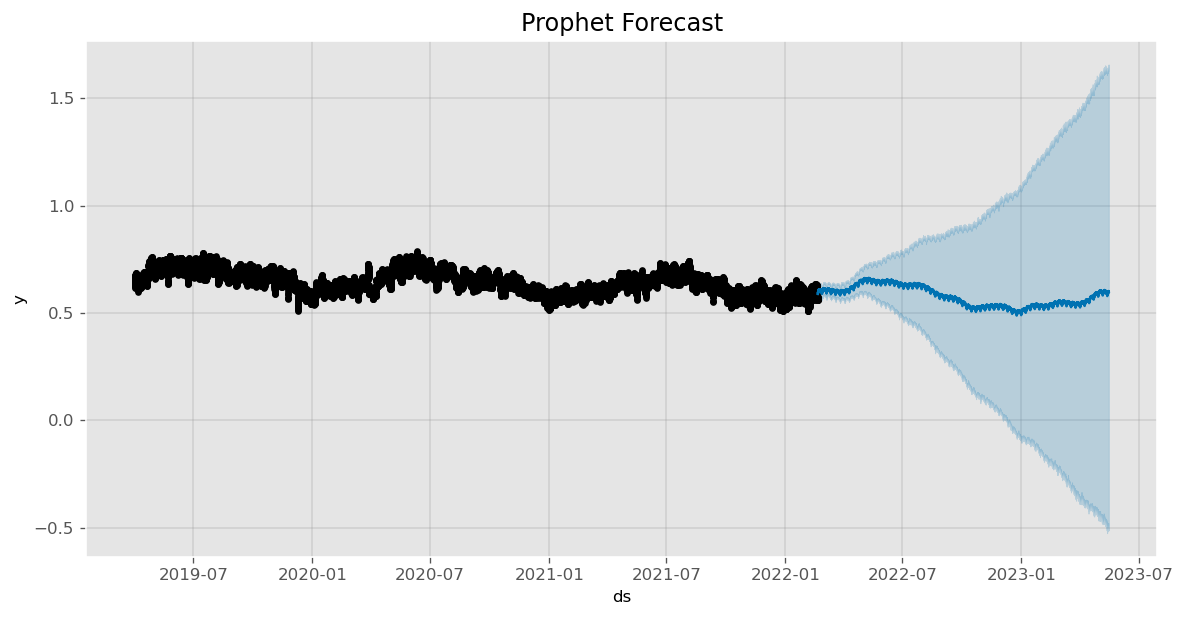

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(EAF_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

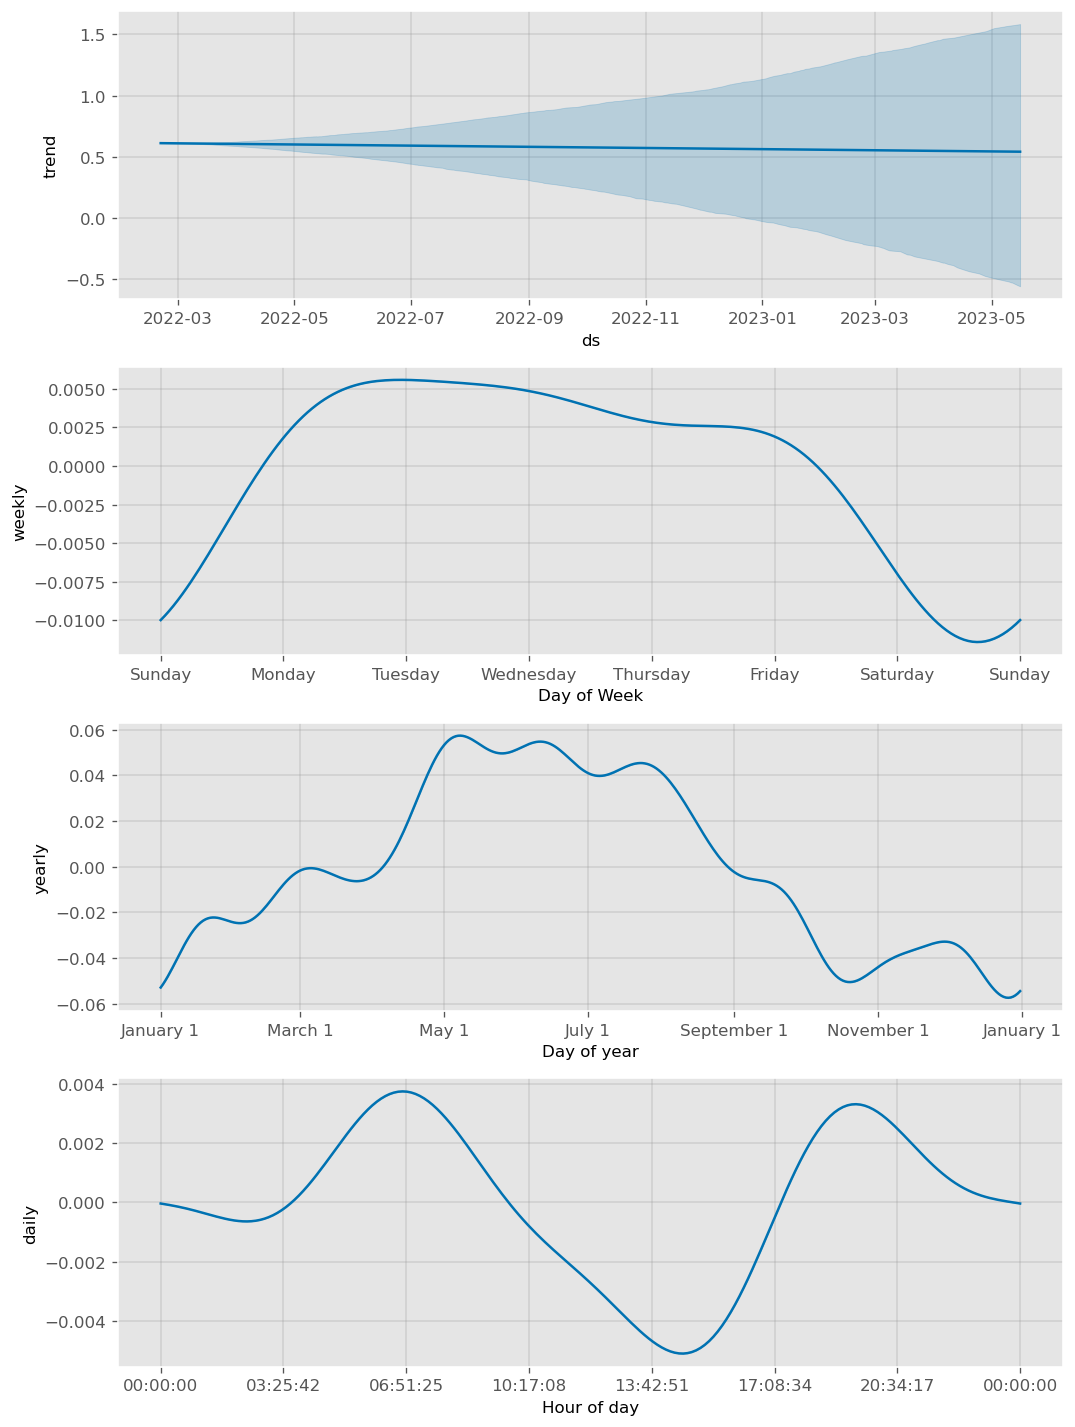

In [26]:
#This plots the components that will show trends in the data
fig = model.plot_components(EAF_test_fcst)
plt.show()

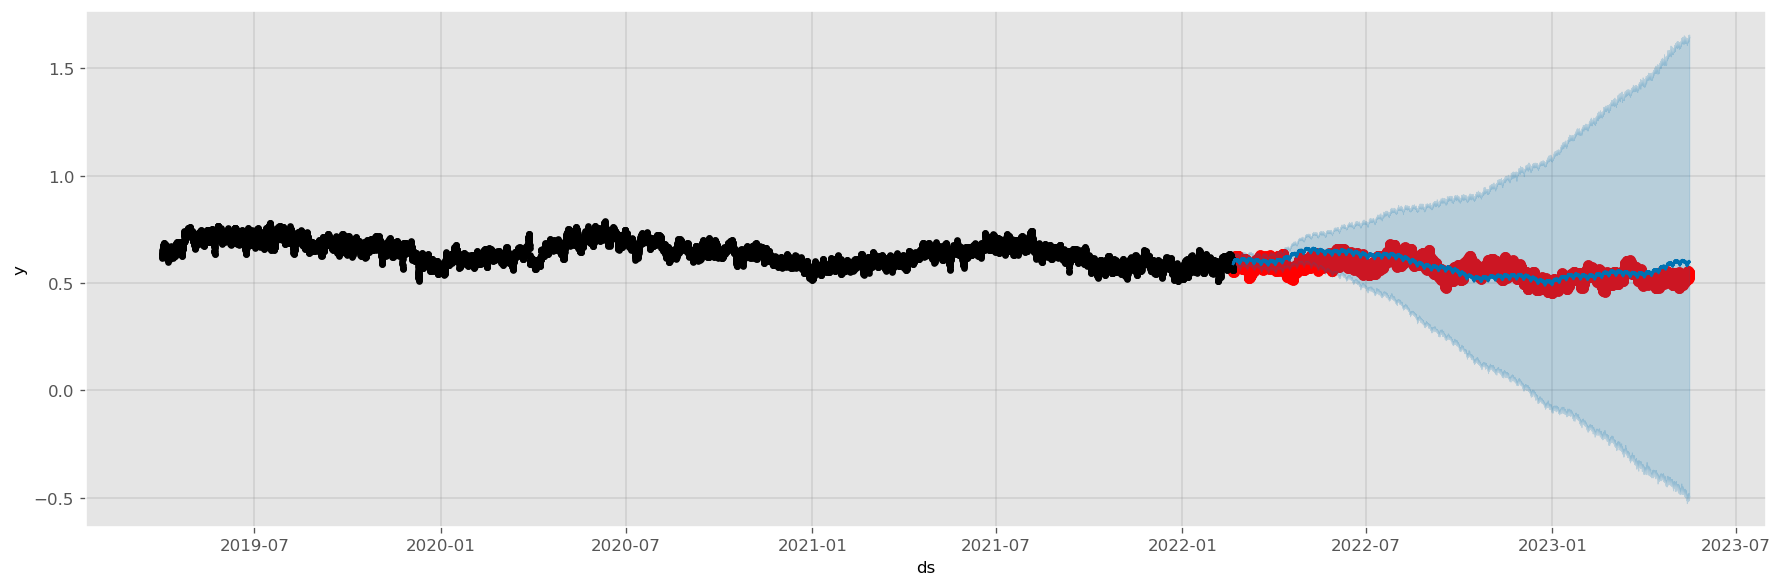

In [27]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(EAF_test.index, EAF_test['EAF'], color='r')
fig = model.plot(EAF_test_fcst, ax=ax)

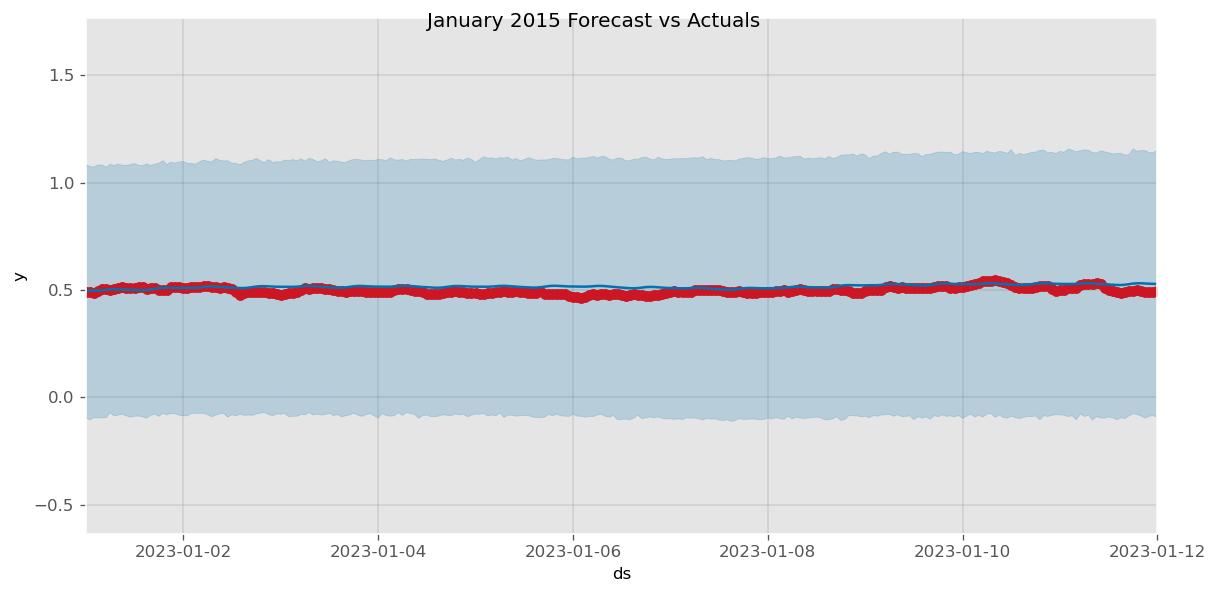

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(EAF_test.index, EAF_test['EAF'], color='r')
fig = model.plot(EAF_test_fcst, ax=ax)
ax.set_xbound(lower=dt.date(2023,1,1),
              upper=dt.date(2023,1,12))
#ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

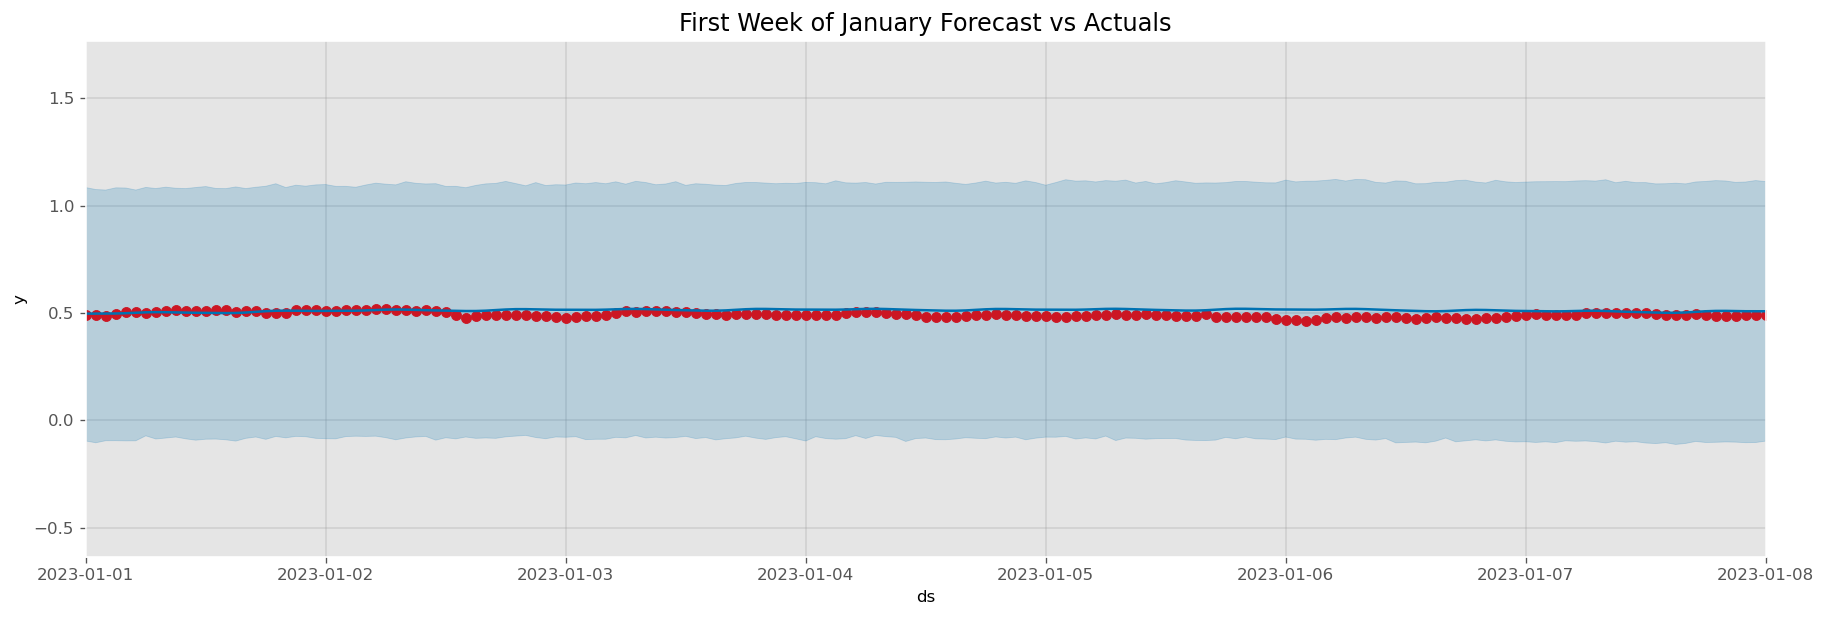

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(EAF_test.index, EAF_test['EAF'], color='r')
fig = model.plot(EAF_test_fcst, ax=ax)
ax.set_xbound(lower=dt.date(2023,1,1), upper=dt.date(2023,1,8))
#ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [30]:
np.sqrt(mean_squared_error(y_true=EAF_test['EAF'],
                   y_pred=EAF_test_fcst['yhat']))

0.03994458913255487

In [31]:
mean_absolute_error(y_true=EAF_test['EAF'],
                   y_pred=EAF_test_fcst['yhat'])

0.03238239095726363

In [32]:
mean_absolute_percentage_error(y_true=EAF_test['EAF'],
                   y_pred=EAF_test_fcst['yhat'])

5.8244736757545725

In [33]:
future = model.make_future_dataframe(periods=650*24, freq='h', include_history=False)
forecast = model.predict(future)

In [34]:
forecast[['ds','yhat']].tail()

,ds,yhat
15595,2023-12-01 20:00:00,0.473822
15596,2023-12-01 21:00:00,0.472195
15597,2023-12-01 22:00:00,0.470546
15598,2023-12-01 23:00:00,0.469427
15599,2023-12-02 00:00:00,0.468694


In [35]:
forecast  = forecast.loc[(forecast['ds'] > '2023-05-16') & (forecast['ds'] < '2023-11-17') ]
forecast.set_index('ds', inplace = True)

FutureData['EAF'] = forecast['yhat']

### EAF scenario2

Scenrio 2 is based on Eskom reaching an EAF of 65% by end of the six months. So the EAF at 2023-11-15 will be 65%

In [36]:
FutureData['EAF_2'] = 0.65

In [37]:
FutureData['EAF_2'].head()

Datetime
2023-05-16 01:00:00    0.65
2023-05-16 02:00:00    0.65
2023-05-16 03:00:00    0.65
2023-05-16 04:00:00    0.65
2023-05-16 05:00:00    0.65
Name: EAF_2, dtype: float64

### EAF scenario3

Based soley on 2023 data, such that the EAF is 40% at the end the 6 months

In [38]:
FutureData['EAF_3'] = 0.45

In [39]:
FutureData['EAF_3'].head()

Datetime
2023-05-16 01:00:00    0.45
2023-05-16 02:00:00    0.45
2023-05-16 03:00:00    0.45
2023-05-16 04:00:00    0.45
2023-05-16 05:00:00    0.45
Name: EAF_3, dtype: float64

In [40]:
Operating_Reserve = 3800 #MW

## Renewable Energy EAF

Now we can calculate the available energy that is available to meet deemand. 

<b>Available_generation</b> = EskomCapacity*EAF + TotalRenewableEnergy + Imports -Exports - Operating reserve.

We can rewrite the TotalRenewableEnergy as the total Renewable Energy installed Capacity multiplied by the Renewable enrgy EAF (<b>EAF_R</b>). This will come in handy when forecasting.

In [41]:
Dataset['EAF_R'] = Dataset['Total RE']/Dataset['Total RE Installed Capacity']

<Axes: title={'center': 'Monthly EAF_R'}, xlabel='Time(Months)', ylabel='Energy (MW)'>

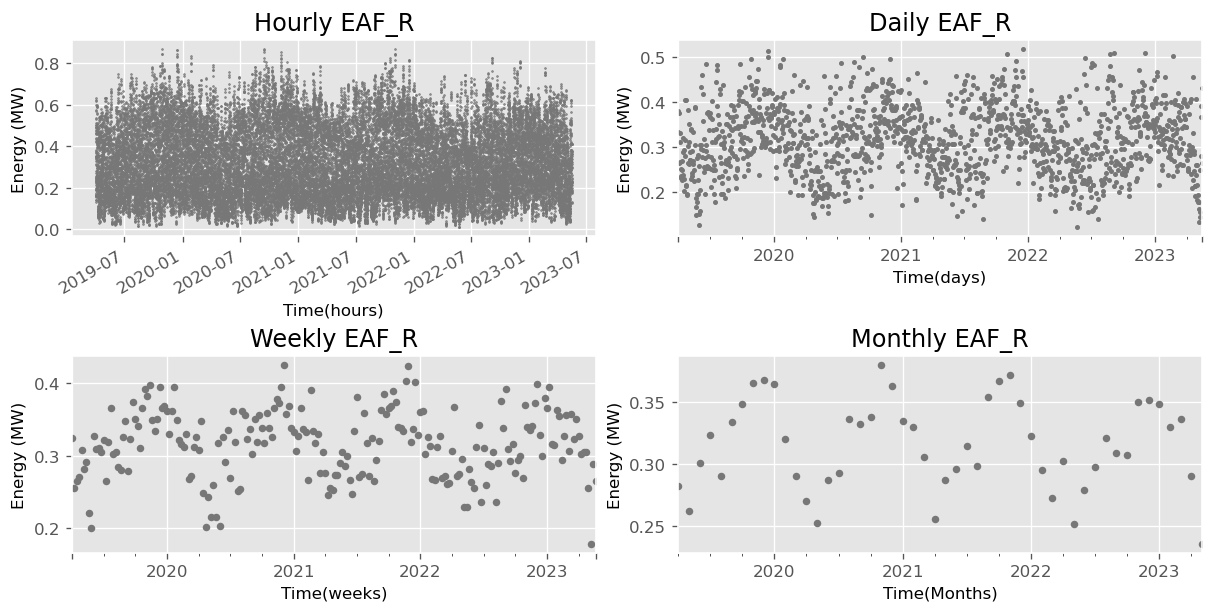

In [42]:
fig, ax = plt.subplots(2,2, figsize=(10,8),constrained_layout = True)

Dataset['EAF_R'].plot(ax=ax[0,0],style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[3],
          title='Hourly EAF_R', ylabel='Energy (MW)',xlabel = 'Time(hours)')
                      
Dataset['EAF_R'].resample('D').mean().plot(ax=ax[0,1],style='.',
          figsize=(10, 5),
          ms=4,
          color=color_pal[3],
          title='Daily EAF_R', ylabel='Energy (MW)',xlabel = 'Time(days)')
                                           
Dataset['EAF_R'].resample('W').mean().plot(ax=ax[1,0],style='.',
          figsize=(10, 5),
          ms=7,
          color=color_pal[3],
          title='Weekly EAF_R', ylabel='Energy (MW)',xlabel = 'Time(weeks)')
                                           
Dataset['EAF_R'].resample('M').mean().plot(ax=ax[1,1],style='.',
          figsize=(10, 5),
          ms=7,
          color=color_pal[3],
          title='Monthly EAF_R', ylabel='Energy (MW)',xlabel = 'Time(Months)')

In [43]:
### Forecasting as we did for EAF

In [44]:
EAF_R = pd.Series.to_frame(Dataset['EAF_R'])

In [45]:
X, y = create_features(EAF_R, label='EAF_R')
features_and_target = pd.concat([X, y], axis=1)

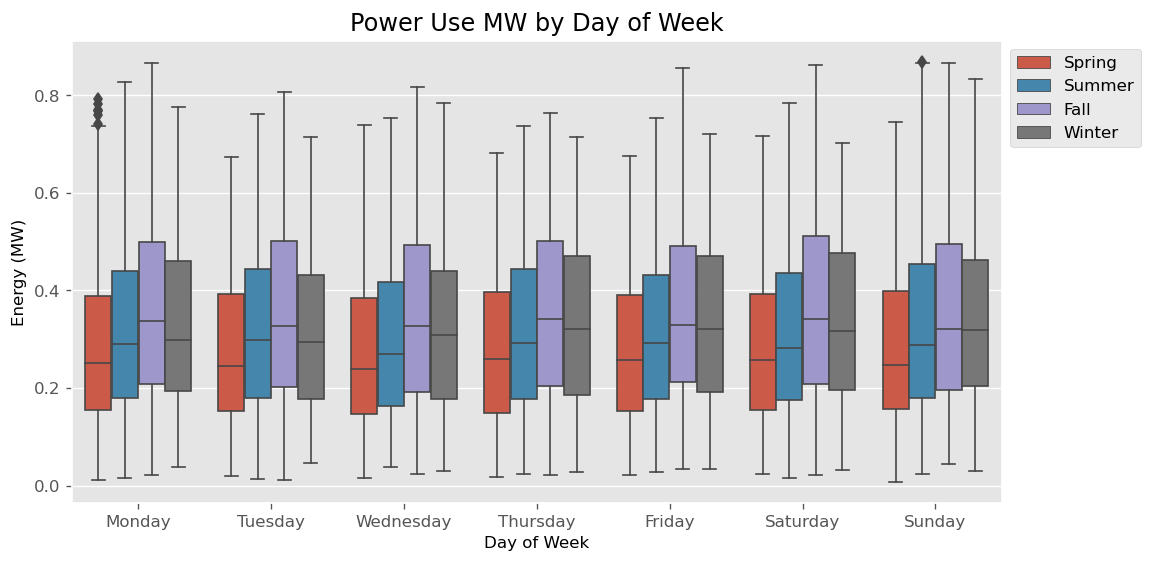

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='EAF_R',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Forecasting EAF_R

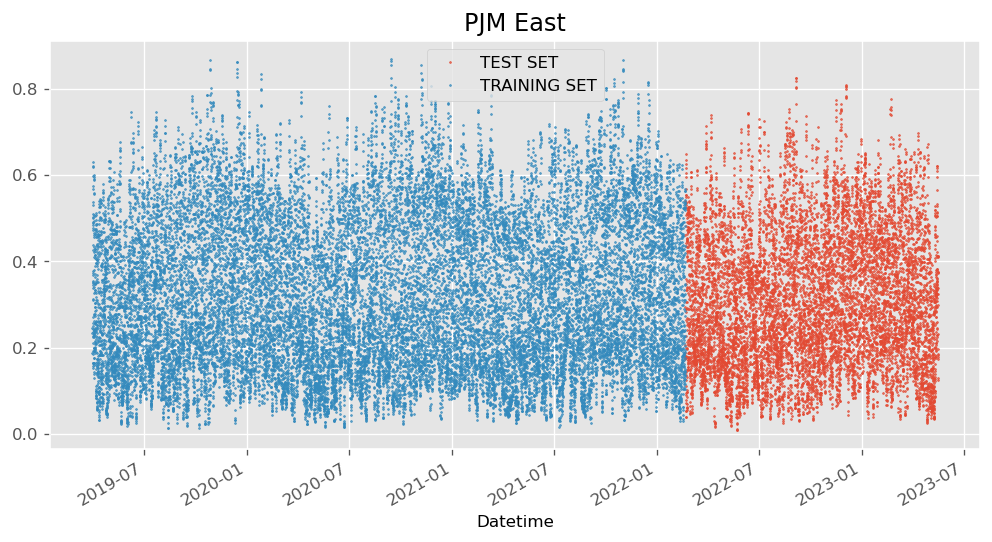

In [47]:
split_date = '20-Feb-2022'
EAF_R_train = EAF_R.loc[EAF_R.index <= split_date].copy()
EAF_R_test = EAF_R.loc[EAF_R.index > split_date].copy()

# Plot train and test so you can see where we have split
EAF_R_test \
    .rename(columns={'EAF_R': 'TEST SET'}) \
    .join(EAF_R_train.rename(columns={'EAF_R': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

In [48]:
# Format data for prophet model using ds and y
EAF_R_train_prophet = EAF_R_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'EAF_R':'y'})

In [49]:
%%time
model = Prophet()
model.fit(EAF_R_train_prophet)

13:38:38 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 4.02 s
Wall time: 15.9 s


In [50]:
# Predict on test set with model
EAF_R_test_prophet = EAF_R_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'EAF_R':'y'})

EAF_R_test_fcst = model.predict(EAF_R_test_prophet)

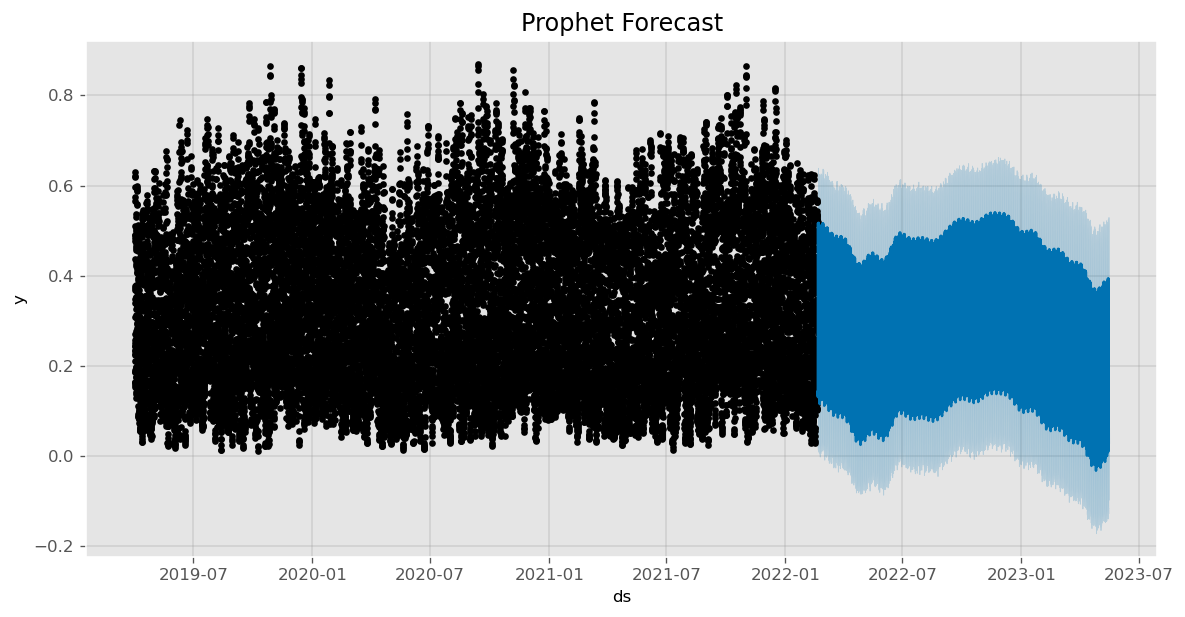

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(EAF_R_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

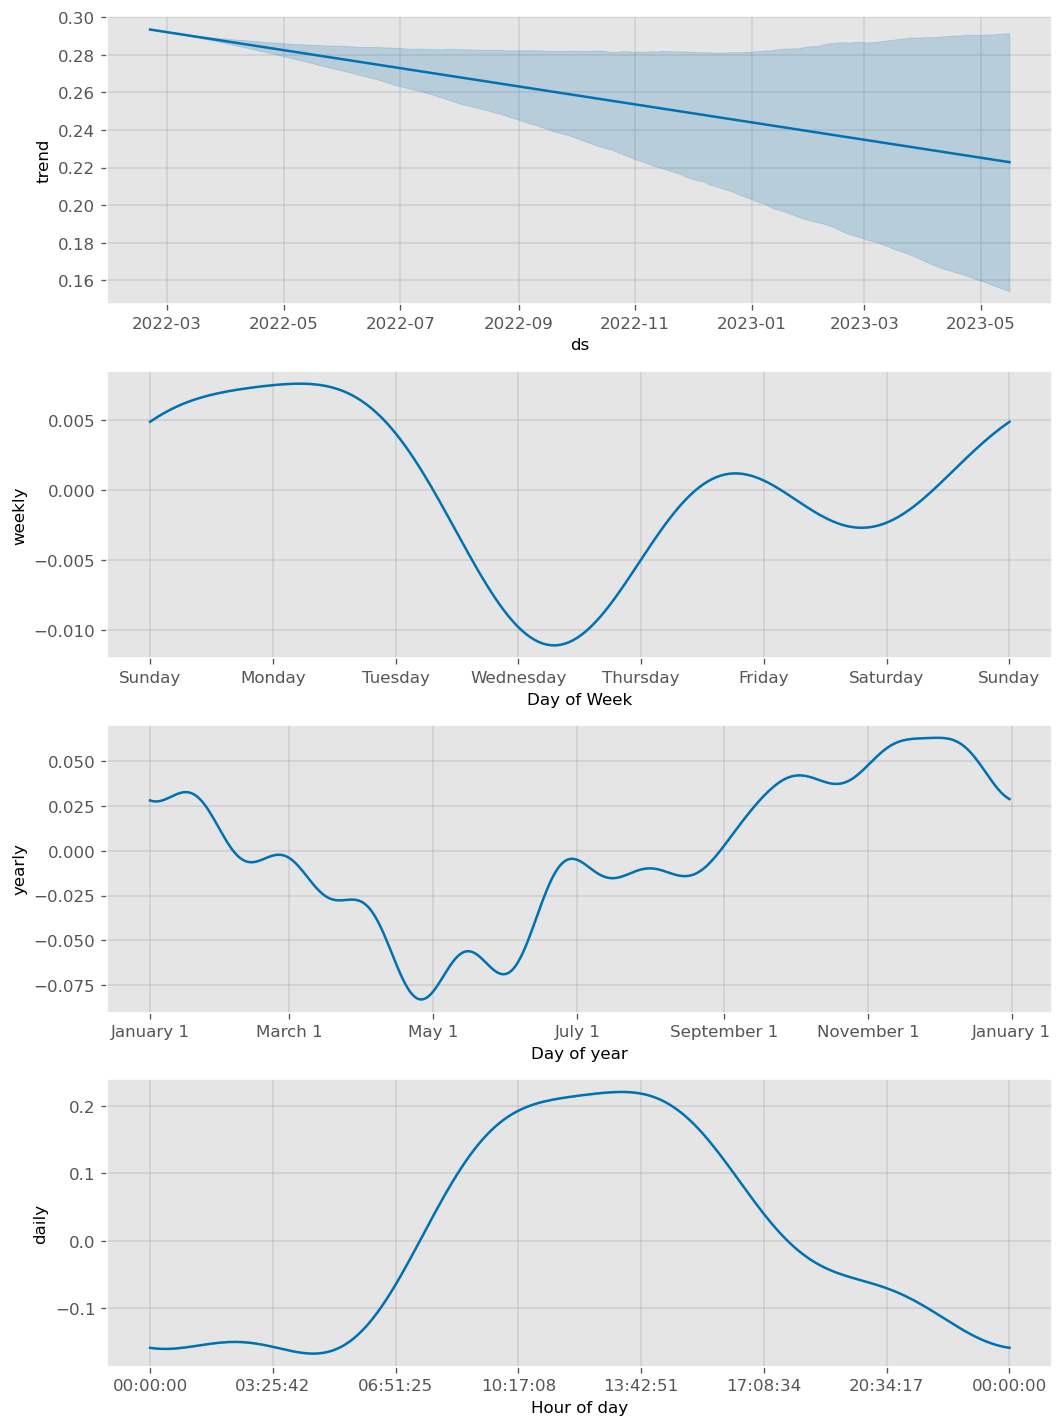

In [52]:
fig = model.plot_components(EAF_R_test_fcst)
plt.show()

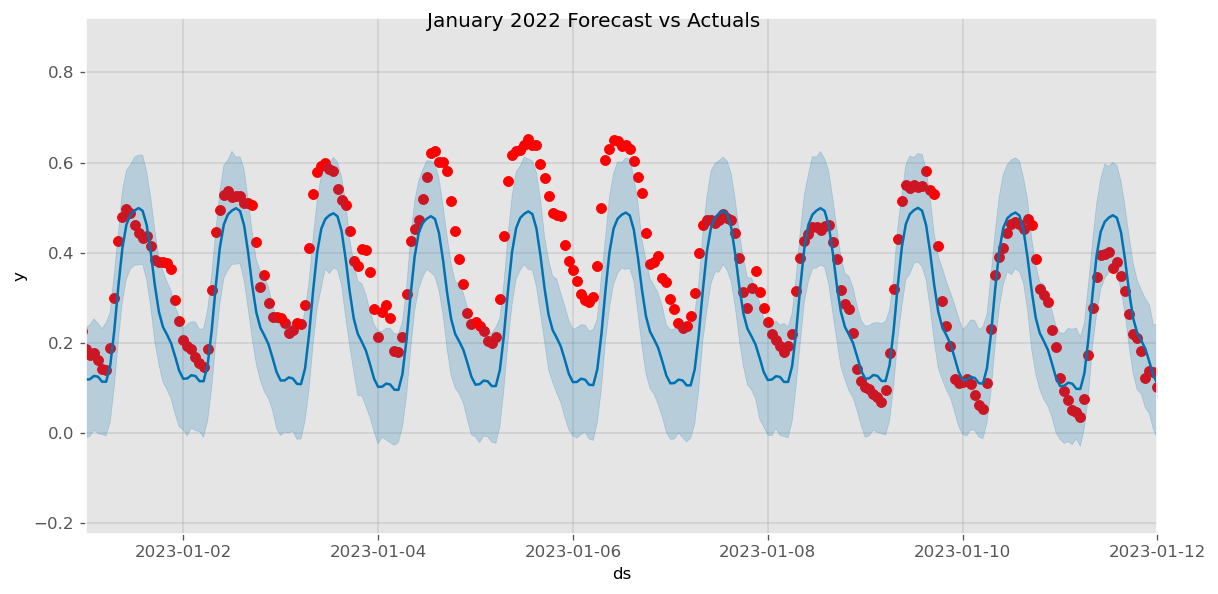

In [53]:
#Comparing our model to Actual January Data

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(EAF_R_test.index, EAF_R_test['EAF_R'], color='r')
fig = model.plot(EAF_R_test_fcst, ax=ax)
ax.set_xbound(lower=dt.date(2023,1,1),
              upper=dt.date(2023,1,12))
#ax.set_ylim(0, 60000)//
plot = plt.suptitle('January 2022 Forecast vs Actuals')

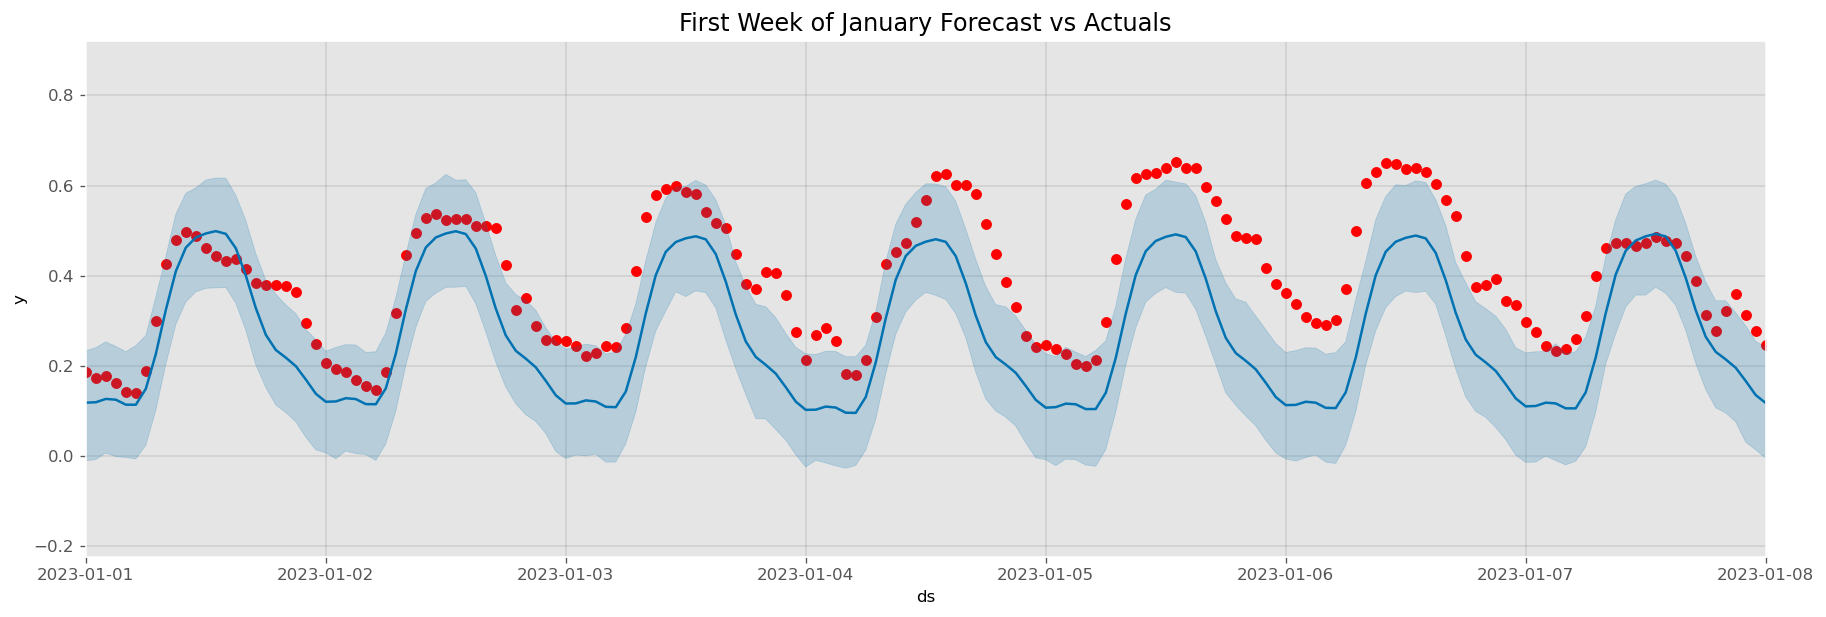

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(EAF_R_test.index, EAF_R_test['EAF_R'], color='r')
fig = model.plot(EAF_R_test_fcst, ax=ax)
ax.set_xbound(lower=dt.date(2023,1,1), upper=dt.date(2023,1,8))
#ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [55]:
np.sqrt(mean_squared_error(y_true=EAF_R_test['EAF_R'],
                   y_pred=EAF_R_test_fcst['yhat']))

0.11682736189378275

In [56]:
mean_absolute_error(y_true=EAF_R_test['EAF_R'],
                   y_pred=EAF_R_test_fcst['yhat'])

0.09300375739369768

In [57]:
mean_absolute_percentage_error(y_true=EAF_R_test['EAF_R'],
                   y_pred=EAF_R_test_fcst['yhat'])

36.04924222701856

In [58]:
future = model.make_future_dataframe(periods=650*24, freq='h', include_history=False)
forecast = model.predict(future)

In [59]:
forecast[['ds','yhat']].tail()

,ds,yhat
15595,2023-12-01 20:00:00,0.191393
15596,2023-12-01 21:00:00,0.172575
15597,2023-12-01 22:00:00,0.143049
15598,2023-12-01 23:00:00,0.111583
15599,2023-12-02 00:00:00,0.093891


In [60]:
forecast  = forecast.loc[(forecast['ds'] > '2023-05-16') & (forecast['ds'] < '2023-11-17') ]
forecast.set_index('ds', inplace = True)

FutureData['EAF_R'] = forecast['yhat']

In [61]:
FutureData.head()

,Residual Forecast,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,Eskom Gas Generation,...,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours,Unnamed: 42,EAF,EAF_2,EAF_3,EAF_R
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-16 01:00:00,20727.707,21591.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.599172,0.65,0.45,0.012621
2023-05-16 02:00:00,20520.313,21413.825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.598818,0.65,0.45,0.019314
2023-05-16 03:00:00,20846.602,21671.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.598862,0.65,0.45,0.016862
2023-05-16 04:00:00,22541.374,23353.149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.599732,0.65,0.45,0.005095
2023-05-16 05:00:00,25801.719,26612.074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.601249,0.65,0.45,0.004241


## Imports And Exports

For Imports and exports we can use their mean for 2023 the a the value we will use 

In [62]:
Data2023 = dataset.loc[(dataset['Datetime'] > '2023-01-01') & (dataset['Datetime'] < '2023-05-16') ]

<Axes: >

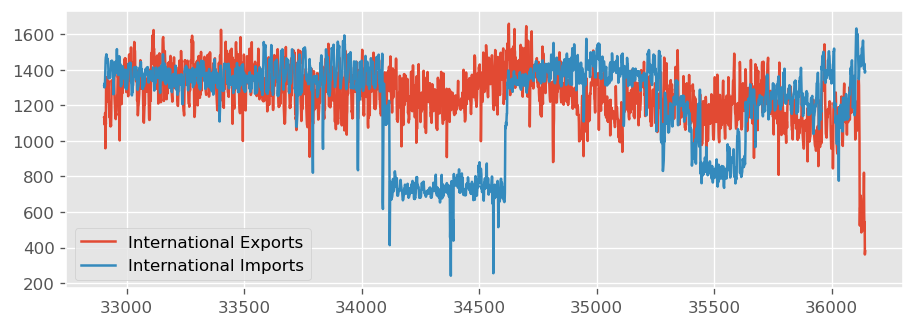

In [63]:
Data2023[['International Exports','International Imports']].plot()

In [64]:
FutureData['International Imports'] = Data2023['International Imports'].mean()
FutureData['International Exports'] = Data2023['International Exports'].mean()

We are now only missing the eskom and reneable enrgy capacities. However we can assume these values will remain the same throughout the year

<Axes: title={'center': 'Installed Eskom Capacity'}, ylabel='Energy (MW)'>

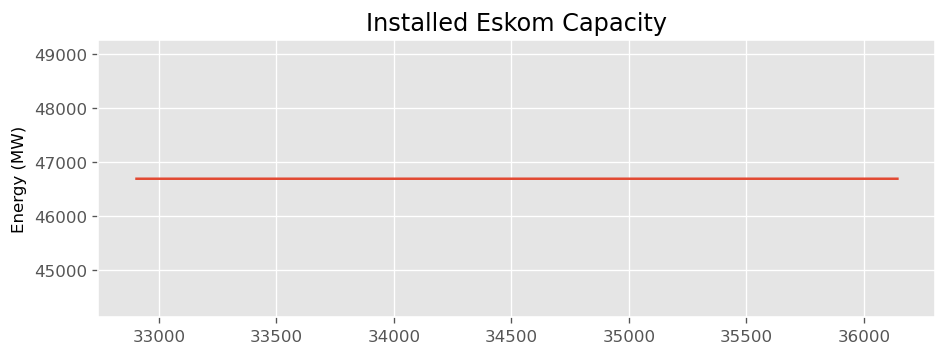

In [65]:
Data2023['Installed Eskom Capacity'].plot(title='Installed Eskom Capacity',ylabel='Energy (MW)')

In [66]:
FutureData['Installed Eskom Capacity'] = Data2023['Installed Eskom Capacity'].mean()


<Axes: title={'center': 'Total RE Installed Capacity'}, ylabel='Energy (MW)'>

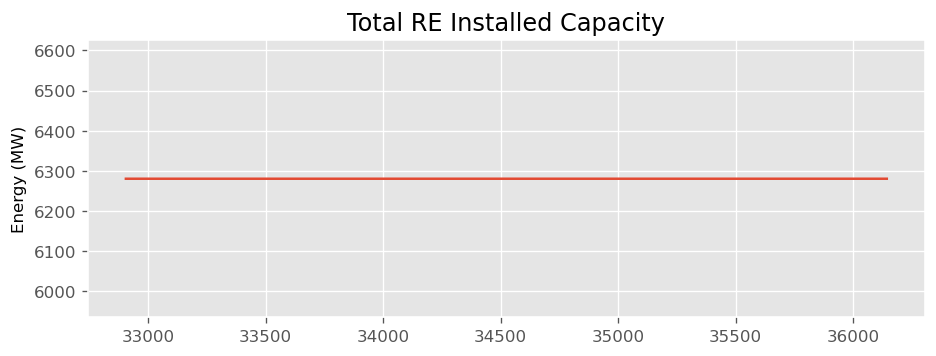

In [67]:
Data2023['Total RE Installed Capacity'].plot(title='Total RE Installed Capacity',ylabel='Energy (MW)')

In [68]:
FutureData['Total RE Installed Capacity'] = Data2023['Total RE Installed Capacity'].mean()

In [69]:
#Removing all the columns with NAN
FutureData = FutureData.dropna(axis = 1, how = 'all')

### Now we can calculate the energy available to dispatch 

In [70]:
# Scenario1 EAF from prophet model  
FutureData['Available_generation'] = ( FutureData['Installed Eskom Capacity']*(FutureData['EAF']) + 
    FutureData['Total RE Installed Capacity']*(FutureData['EAF_R']) - FutureData['International Exports']
                                      + FutureData['International Imports']
                                 )


In [71]:
#Calculate the energy remaining after dispatch or the shortfall needed

FutureData['Surplus'] = FutureData['Available_generation'] - FutureData['RSA Contracted Forecast']

## Calculating the amount of energy to be shed
One would think to calculate the amount of energy to be shed, we can just sum all the values of available energy minus the demand. Hovever that is not true. We only need to sum the negative numbers. This is because if there is excess energuy at time t1, that excess energy cannot be used to supply a shortfall in energy at time t2. Electricity is not stored. Rather only the eqivalent of the demand is supllied, not more.

In [97]:
LoadShed = (FutureData['Surplus'][(FutureData['Surplus'] < 0)]).sum()

print('The load to be shed in 6months for prophet model is',LoadShed,'Megawatts')

The load to be shed in 6months for prophet model is -19947801.637299202 Megawatts


In [98]:
LoadShed 

-19947801.637299202

In [99]:
#Scenario2 EAF = 65%

In [100]:
# Scenario1 EAF from prophet model  
FutureData['Available_generation'] = ( FutureData['Installed Eskom Capacity']*(FutureData['EAF_2']) + 
    FutureData['Total RE Installed Capacity']*(FutureData['EAF_R']) - FutureData['International Exports']
                                      + FutureData['International Imports']
                                 )
FutureData['Surplus'] = FutureData['Available_generation'] - FutureData['RSA Contracted Forecast']
LoadShed2 =(FutureData['Surplus'][(FutureData['Surplus'] < 0)]).sum()

print('The load to be shed in 6months for EAF equal to 65% is ',LoadShed2,'Megawatts')

The load to be shed in 6months for EAF equal to 65% is  -179772.25197533416 Megawatts


In [101]:
# Scenario1 EAF from prophet model  
FutureData['Available_generation'] = ( FutureData['Installed Eskom Capacity']*(FutureData['EAF_3']) + 
    FutureData['Total RE Installed Capacity']*(FutureData['EAF_R']) - FutureData['International Exports']
                                      + FutureData['International Imports']
                                 )
FutureData['Surplus'] = FutureData['Available_generation'] - FutureData['RSA Contracted Forecast']
LoadShed3 = (FutureData['Surplus'][(FutureData['Surplus'] < 0)]).sum()

print('The load to be shed in 6months for EAF equal to 45% is',LoadShed3,'Megawatts')

The load to be shed in 6months for EAF equal to 45% is -19947801.637299202 Megawatts


In [102]:
LoadShed3

-19947801.637299202

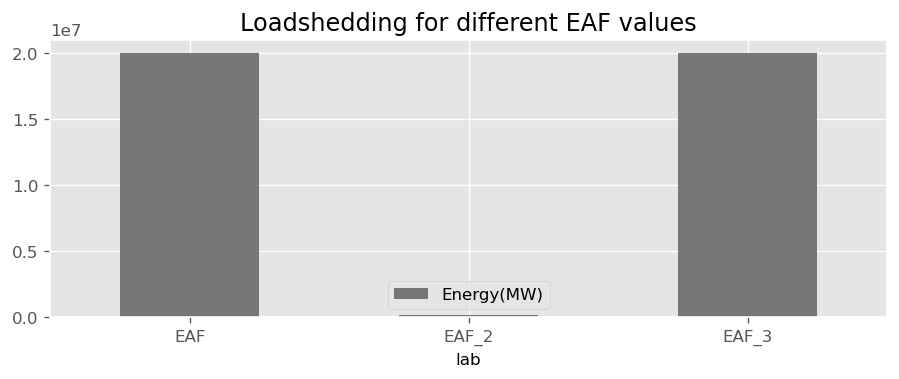

In [108]:
df = pd.DataFrame({'lab':['EAF', 'EAF_2', 'EAF_3'], 'Energy(MW)':[abs(LoadShed),abs(LoadShed2),abs(LoadShed3)]})
ax = df.plot.bar(x='lab', y='Energy(MW)', rot=0,color=color_pal[3],title='Loadshedding for different EAF values')

# The End

## BONUS! WE can also look at load shedding for past times

In [123]:
Dataset['Surplus'] = Dataset['Dispatchable Generation'] - Dataset['RSA Contracted Demand']

In [124]:
LoadShed = (Dataset['Surplus'][(Dataset['Surplus'] < 0)])

In [126]:
# Differe values of energy for each yaer shedded
abs(LoadShed).resample('Y').sum()

Datetime
2019-12-31    9.296930e+06
2020-12-31    1.387997e+07
2021-12-31    1.712377e+07
2022-12-31    2.447432e+07
2023-12-31    1.553457e+07
Freq: A-DEC, Name: Surplus, dtype: float64

<Axes: xlabel='Datetime', ylabel='Energy (MW)'>

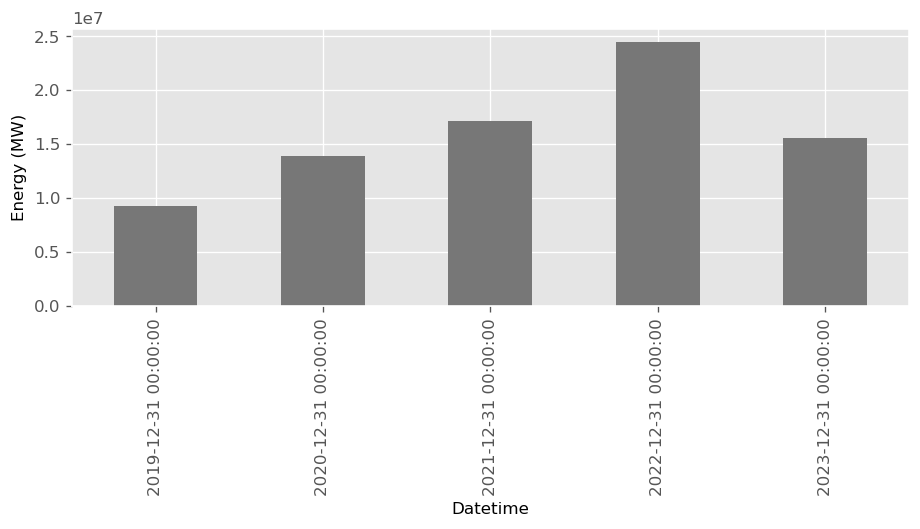

In [125]:
abs(LoadShed).resample('Y').sum().plot.bar(ylabel='Energy (MW)',color=color_pal[3])

<Axes: title={'center': 'Different EAF scenarios'}, xlabel='Datetime'>

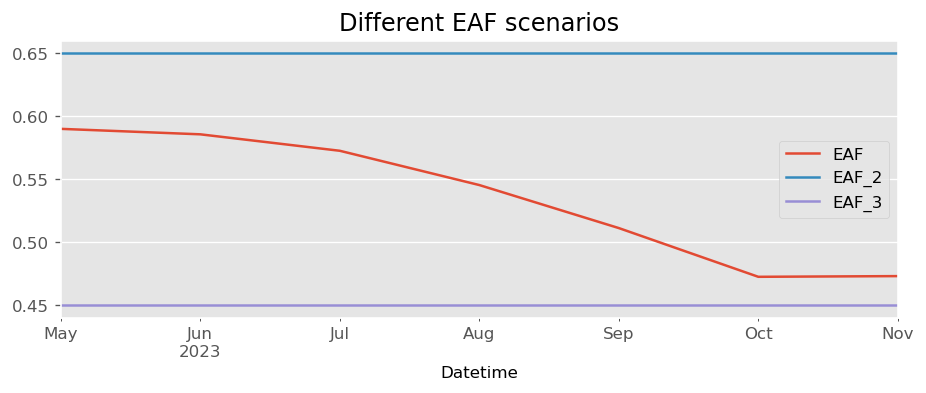

In [120]:

FutureData[['EAF','EAF_2','EAF_3']].resample('M').mean().plot(title='Different EAF scenarios')

In [110]:
YearEAF

Datetime
2019-12-31    0.681374
2020-12-31    0.650405
2021-12-31    0.617708
2022-12-31    0.579855
2023-12-31    0.525885
Freq: A-DEC, Name: EAF, dtype: float64

In [130]:
Dataset['RSA Contracted Forecast'].resample('Y').mean()

Datetime
2019-12-31    26552.374330
2020-12-31    25135.275616
2021-12-31    25942.506319
2022-12-31    25947.263873
2023-12-31    25796.436442
Freq: A-DEC, Name: RSA Contracted Forecast, dtype: float64